## Задача регрессии

- Выполнил: Ларин А.В.
- Группа: М8О-103М-20
- Исследуемый датасет: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

Описание задачи: требуется предсказать популярность трека в зависимости от ключевых описательных признаков (взяты композиции с 2000 года включительно).

Импорт библиотек:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Загрузка обработанного датасета для композиций 21-го века:

In [2]:
df = pd.read_csv('processed_spotify_data_XXI.csv')
del df['Unnamed: 0']
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.394,['Gerry & The Pacemakers'],0.484,160187,0.265,0,0.000000,0,0.149,-11.101,1,You'll Never Walk Alone - Mono; 2002 Remaster,55,2008-02-11,0.0322,113.564,0.285,2008
1,0.255,['Gerry & The Pacemakers'],0.405,141987,0.365,0,0.000005,6,0.163,-10.226,0,Ferry Cross the Mersey - Mono; 2002 Remaster,39,2008-02-11,0.0289,104.536,0.588,2008
2,0.406,['Gerry & The Pacemakers'],0.477,157093,0.352,0,0.000000,1,0.122,-14.165,1,Don't Let the Sun Catch You Crying (Main) - Mono,34,2008-02-11,0.0300,106.773,0.478,2008
3,0.887,['Frank Sinatra'],0.319,187333,0.201,0,0.000000,7,0.904,-17.796,1,The September Of My Years - Live At The Sands ...,27,2018-05-04,0.0623,117.153,0.239,2018
4,0.938,['Frank Sinatra'],0.269,236800,0.129,0,0.000005,7,0.683,-18.168,0,It Was A Very Good Year - Live At The Sands Ho...,26,2018-05-04,0.0576,82.332,0.160,2018


Описание признаков, содержащихся в записях датасета Spotify:

- acousticness - мера достоверности того, записан ли трек с использованием реальных инструментов (от 0 до 1).

- danceability - мера "танцевальности" трека (от 0 до 1).

- duration_ms - длительность в миллисекундах.

- energy - энергетика трека (от 0 до 1).

- explicit - содержание нецензурной лексики (0 - нет, 1 - да).

- instrumentalness - мера общего количества вокальных партий (от 0 до 1).

- key - тоника трека (от 0 до 11). Если не определена, то -1.

- liveness - вероятность того, что трек был записан вживую (от 0 до 1).

- loudness - громкость трека (от -60 до 0 Децибел).

- mode - тональность трека (мажорная - 1, минорная - 0).

- popularity - мера популярности трека (от 0 до 100).

- speechiness - мера количества речи в треке (от 0 до 1).

- tempo - темп трека в BPM.

- valence - настроение трека (от 0 до 1, от негативного до позитивного).

Построение гистограмм для датасета:

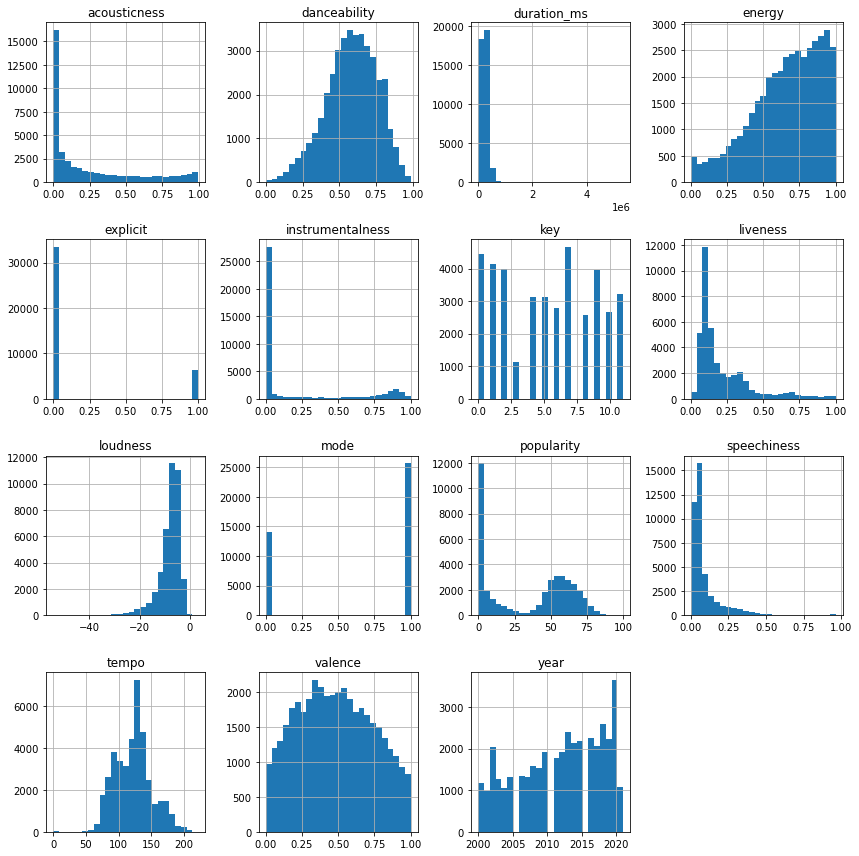

In [3]:
df.hist(figsize = (12, 12), bins = 25)
plt.tight_layout()
plt.show()

Выделение числовых и строковых признаков:

In [4]:
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']

print("Количество числовых колонок: {0}\nКоличество числовых колонок: {1}".format(len(numeric_columns), len(string_columns)))

Количество числовых колонок: 15
Количество числовых колонок: 3


Построение корреляционной матрицы:

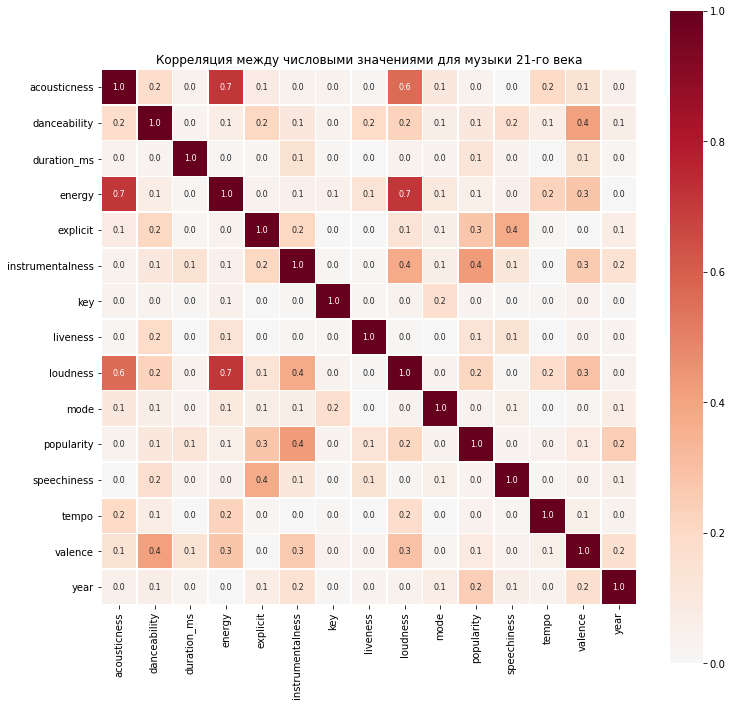

In [5]:
numeric_df = pd.DataFrame(data = df, columns = numeric_columns, index = df.index)
corr = abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, vmax=1, vmin=0, center=0,linewidth=.5, square=True, annot = True, annot_kws = {'size':8},fmt='.1f', cmap='RdBu_r')
plt.title('Корреляция между числовыми значениями для музыки 21-го века')
plt.show()

Исходя из данных корреляционной матрицы, можно сделать вывод о том, что популярность наиболее сильно зависит от наличия нецензурной лексики, меры вокальных партий, громкости и года выпуска.

Выделение данных по выбранным признакам:

In [6]:
features = ['explicit', 'instrumentalness', 'loudness', 'year']
features_df = df[features]

Построение диаграмм рассеяния для выбранных признаков:

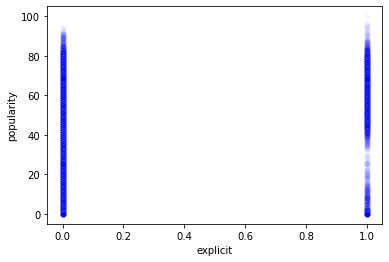

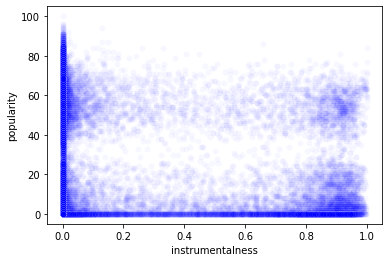

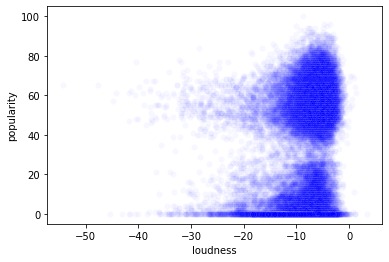

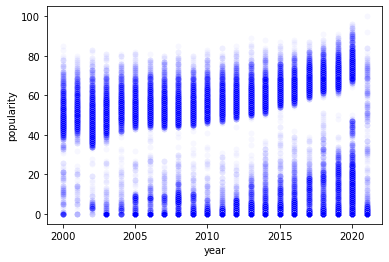

In [7]:
for feature in features:
    sns.scatterplot(x = feature, y = "popularity", data = df, alpha=0.03, color='blue')
    plt.pause(0.05)

plt.show()

Учитывая то, что популярность трека в любом случае сильно зависит от популярности исполнителей, следует учитывать общую популярность исполнителей на основе средней популярности всех их треков (парсинг может занять некоторое время):

In [8]:
class Artist: 
    def __init__(self, name, popularity): 
        self.name = name
        self.popularity = popularity
        
        
class Track: 
    def __init__(self, name, artists, popularity): 
        self.name = name
        self.artists = artists
        self.popularity = popularity  
        

tracks = []

names = df.name.values
artists_names = df.artists.values
popularity = df.popularity.values

for index in range(len(names)): 
    track = Track(names[index], artists_names[index], popularity[index])
    tracks.append(track)
    
    
artists = []
artists_names_done = []
artists_popularities = []

for artists_str in artists_names: 
    artists_sub_list = artists_str[1:-1].split(', ')
    
    track_pop = 0
    
    for artist in artists_sub_list: 
        
        if artist in artists_names_done: 
            a = [x for x in artists if x.name == artist][0]
            artist_pop = a.popularity
            
        else: 
            songs_pop = [x.popularity for x in tracks if artist in x.artists]
            artist_pop = sum(songs_pop) / len(songs_pop)
            artists_names_done.append(artist)
            a = Artist(artist, artist_pop)
            artists.append(a)
        
        track_pop += artist_pop
        
    track_pop /= len(artists_sub_list)
    artists_popularities.append(track_pop)
    
artists_popularities = np.asarray(artists_popularities)

Нормализация и разделение данных на обучающую и тестовую выборку:

In [9]:
scaler = StandardScaler()
scaler.fit(features_df)
features_df = scaler.transform(features_df)

features_df = np.column_stack((artists_popularities / 100, features_df))

y_tracks_data = df.popularity.values / 100

X_train, X_test, y_train, y_test = train_test_split(features_df, y_tracks_data, test_size = 0.25, random_state = 123)

### Линейный регрессор

In [10]:
lr = LinearRegression()  
lr.fit(X_train, y_train)

prediction = lr.predict(X_test)
accuracy = lr.score(X_test, y_test)
print("Точность алгоритма линейной регрессии:", accuracy)

Точность алгоритма линейной регрессии: 0.9257185213103164


### Метод ближайших K соседей

Максимальная точность: 0.9246409785025793 при K = 6


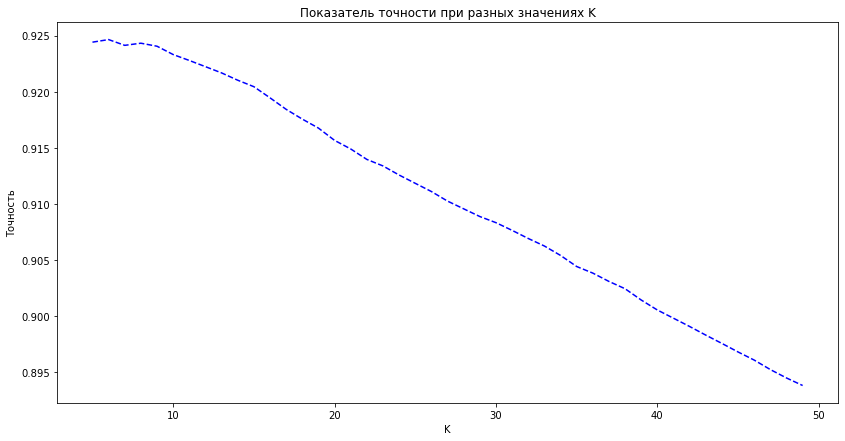

In [11]:
acc = []
default_k = 5

for k in range(default_k, 50):
    knn = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    yhat = knn.predict(X_test)
    acc.append(explained_variance_score(y_test, yhat))
    
plt.figure(figsize = (14, 7))
plt.plot(range(default_k, 50), acc, color = 'blue', linestyle = 'dashed')
plt.title('Показатель точности при разных значениях K')
plt.xlabel('K')
plt.ylabel('Точность')
print("Максимальная точность:", max(acc), "при K =", acc.index(max(acc)) + default_k)

### Метод опорных векторов (SVR)

In [12]:
svr_regr = SVR()
svr_regr.fit(X_train, y_train)
prediction = svr_regr.predict(X_test)
accuracy = svr_regr.score(X_test, y_test)
print("Точность метода опорных векторов:", accuracy)

Точность метода опорных векторов: 0.9258275227449285


### Random Forest (дополнительный метод)

In [13]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)
accuracy = rfr.score(X_test, y_test)
print("Точность метода Random Forest:", accuracy)

Точность метода Random Forest: 0.9428708134804904
